In [1]:
import pandas as pd
import numpy as np
from plotnine import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [12]:
%%bash
rm -f arith.txt
find Benchs -name 'arith.txt' >> arith.txt

In [13]:
files = []
with open('arith.txt') as f:
    for line in f:
        files.append(line.strip())

In [14]:
# insts = ['Add', 'Sub', 'Xor', 'Shl', 'LShr', 'AShr', 'Mul', 'UDiv', 'SDiv', 'And', 'Or']
insts = ['Add', 'Sub', 'Xor', 'Mul', 'FAdd', 'FSub', 'FMul']
header = insts + [ x + '_total' for x in insts]

In [41]:
df = pd.DataFrame(columns=['Benchmark', 'Group'] + header)
for f in files:
    df2 = pd.read_csv(f, header=None).transpose()
    df2.columns = df2.iloc[0]
    df2 = df2[1:]
    d = dict()
    for h in insts:
        try:
            d[h] = float(df2.iloc[0][h])/float(df2.iloc[1][h])
        except:
            d[h] = 0.0
        d[h + '_total'] = df2.iloc[1][h]
    d['Benchmark'] = f.split('/')[1] if len(f.split('/')) == 3 else f.split('/')[2]
    d['file'] = '/'.join(f.split('/')[1:-1])
    d['Group'] = f.split('/')[1]
    df = df.append(d, ignore_index=True)

df = df.round(3)


for h in insts:
    df[h + '_total'] = df[h + '_total'].astype(np.int64)

In [42]:
df.head()

,Benchmark,Group,Add,Sub,Xor,Mul,FAdd,FSub,FMul,Add_total,Sub_total,Xor_total,Mul_total,FAdd_total,FSub_total,FMul_total,file
0,mandel-2,Misc,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0,0,Misc/mandel-2
1,dt,Misc,0.001,0.000,0.000,0.000,1.000,0.000,0.000,134219776,2048,0,0,2048,0,4096,Misc/dt
2,flops-5,Misc,0.000,0.000,0.000,0.000,0.923,0.000,0.000,156249999,0,0,0,2031250001,0,2343750002,Misc/flops-5
3,flops-2,Misc,0.000,0.000,0.000,0.000,0.400,1.000,0.000,0,0,0,0,390625001,234375004,156250003,Misc/flops-2
4,oourafft,Misc,0.007,0.000,0.000,0.000,0.700,0.630,0.000,3175539676,36000515,0,904105,4006838660,4524643966,4089638976,Misc/oourafft


In [51]:
# df.to_clipboard(float_format='%.3f')

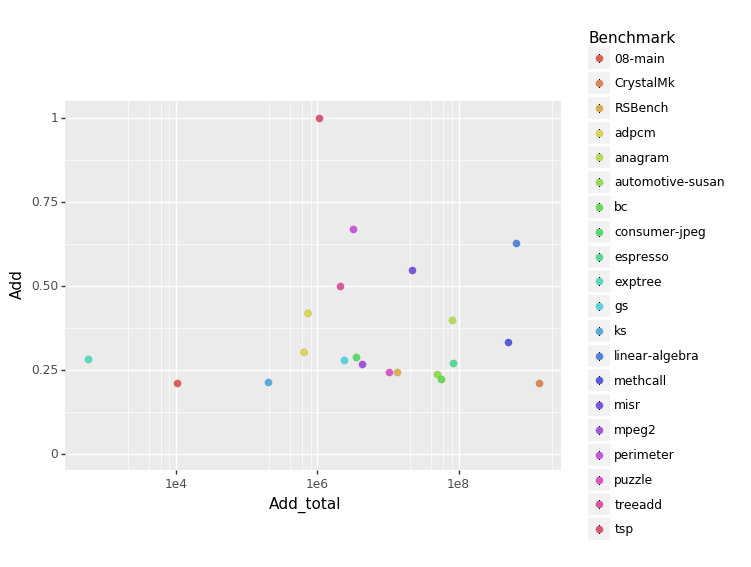

<ggplot: (285316872)>

In [18]:
(ggplot(df[(df.Add > 0.2) & (df.Add_total > 100)])
 + scale_x_log10()
 + geom_point(aes(x='Add_total', y='Add', fill='Benchmark'), stroke=0.02, size=3)
 + ylim((0, 1.0))
)

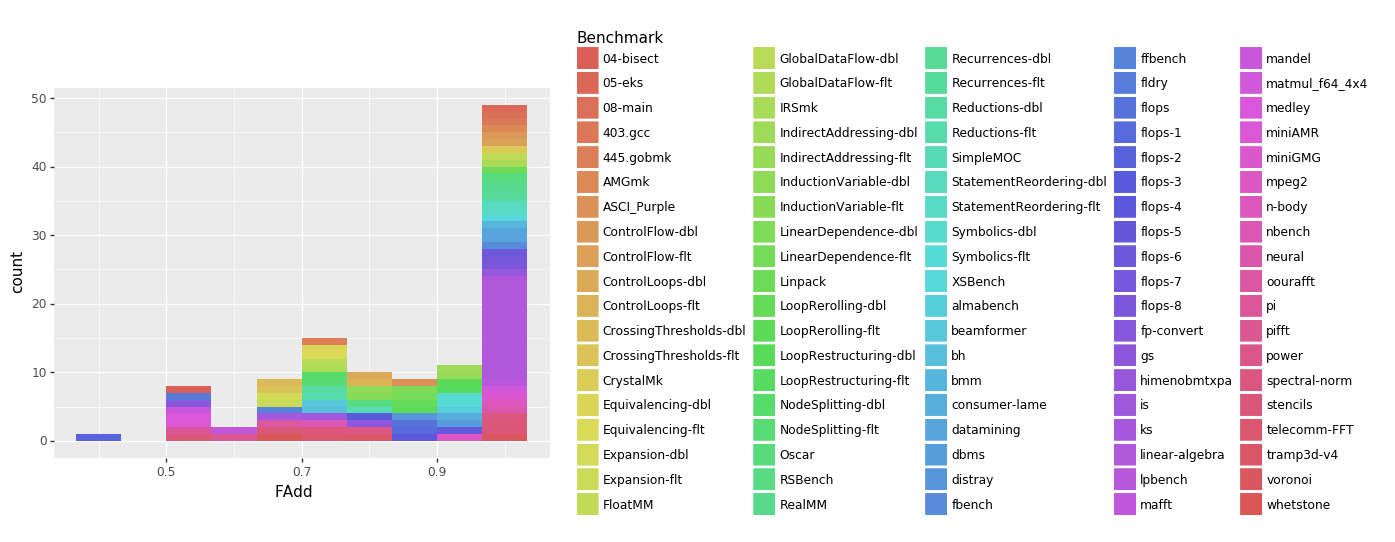

<ggplot: (-9223372036569481072)>

In [30]:
(ggplot(df[(df.FAdd > 0.0) & (df.FAdd_total > 10000)], aes(x='FAdd'))
 + geom_histogram(aes(fill='Benchmark'), bins=10)
)

In [43]:
df.query('(FAdd > 0.9) & (FAdd_total > 10000)')[['Group', 'Benchmark', 'file', 'FAdd', 'FAdd_total']]

,Group,Benchmark,file,FAdd,FAdd_total
2,Misc,flops-5,Misc/flops-5,0.923,2031250001
10,Misc,fbench,Misc/fbench,0.977,44000000
15,Misc,himenobmtxpa,Misc/himenobmtxpa,1.000,402974208
19,Misc,matmul_f64_4x4,Misc/matmul_f64_4x4,1.000,2400000000
22,Misc,flops-6,Misc/flops-6,1.000,2031250001
23,Misc,flops-8,Misc/flops-8,1.000,2031250001
24,Misc,flops-7,Misc/flops-7,1.000,468750002
44,PolyBench,datamining,PolyBench/datamining/correlation,0.999,501500000
45,PolyBench,datamining,PolyBench/datamining/covariance,0.999,501500000
47,PolyBench,stencils,PolyBench/stencils/adi,1.000,3145728
